# Objetivo del notebook

Este fichero Jupyter tiene como objetivo diseñar una estructura de red residual que, tomando los parametros de una red preentrenada, puede ser optimizada para el caso que enfrentamos. El objetivo principal es tratar de incrementar, en la medida de lo posible, el rendimiento de la CNN entrenada previamente (con aumento de datos, **cnn_modeling.ipynb**).

---

<br>
<br>
<br>

## Importar las librerías a utilizar

En la siguiente celda se importan todas las librerías que se utilizan en el presente fichero Jupyter.

In [1]:
# Librerías de procesamiento y manipulación de datos
import numpy as np

# Librerías de visualización
import matplotlib.pyplot as plt
import cv2 as cv

# Librerías para la construcción de la red convolucional
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from keras import Input
from keras import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50 # no funciona correctamente
from keras.applications import EfficientNetB0 # no funciona correctamente
from keras.applications import InceptionResNetV2
from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications import VGG16
from keras.applications import MobileNet

# Otros
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings(action = "ignore")

---

<br>
<br>
<br>

## Cargo el conjunto de datos

Para entrenar la red residual, utilizo el conjunto aumentado que he creado para el entrenamiento de la red convolucional del fichero **cnn_modeling.ipynb**.

In [2]:
# Defino las rutas donde se alojan cada conjunto de datos
train_path = "../processed_data_aug/train/"
val_path = "../processed_data_aug/val/"
test_path = "../processed_data_aug/test/"


# Instancio un objeto de la clase ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1. / 255,
)

batch_size = 150

# Defino los subconjuntos de datos con datagen.flow_from_directory()
train_data = datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle=True,
    batch_size=batch_size,
    class_mode="binary"
)

val_data = datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle=False,
    batch_size=batch_size,
    class_mode="binary"
)

test_data = datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle=False,
    batch_size=batch_size,
    class_mode="binary"
)

Found 55458 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


---

<br>
<br>
<br>

## Desarrollo de la red residual

Para llevar a cabo el proceso de aprendizaje por transferencia, voy a utilizar la red InceptionV3, a la cual le cargo los parametros para el dataset de "imagenet".

In [3]:
# Cargamos el modelo pre-entrenado
pre_trained_model = InceptionV3(
    weights="imagenet",
    input_shape= (224, 224, 3),
    include_top=False # No queremos incluir la "cabeza" de clasificación de Imagenet de 1000 clases
)

# Congelamos los parámetros del modelo base
pre_trained_model.trainable=False

# Creamos un nuevo modelo sobre él  
input = Input(shape=(224, 224, 3))

output = pre_trained_model(input, training=False)
output = GlobalAveragePooling2D()(output)
output = Dense(1, activation="sigmoid")(output)

# Construyo el modelo
model = Model(inputs=input,
              outputs=output,
              name="residual_net_aug")

# Compilo el modelo
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Reviso la arquitectura de la red residual
model.summary()

Model: "residual_net_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [4]:
# Entreno el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../src/trained_models/residual_net_aug.h5', save_best_only=True, monitor='val_loss')

# Entreno el modelo
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50, 
    steps_per_epoch=train_data.samples // batch_size,
    validation_steps=val_data.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
369/369 [==============================] - 49s 123ms/step - loss: 0.6938 - accuracy: 0.5513 - val_loss: 0.6011 - val_accuracy: 0.6973
Epoch 2/50
369/369 [==============================] - 45s 121ms/step - loss: 0.6650 - accuracy: 0.5901 - val_loss: 0.5407 - val_accuracy: 0.7600
Epoch 3/50
369/369 [==============================] - 45s 122ms/step - loss: 0.6511 - accuracy: 0.6035 - val_loss: 0.5112 - val_accuracy: 0.7827
Epoch 4/50
369/369 [==============================] - 45s 121ms/step - loss: 0.6421 - accuracy: 0.6128 - val_loss: 0.4641 - val_accuracy: 0.8187
Epoch 5/50
369/369 [==============================] - 44s 120ms/step - loss: 0.6359 - accuracy: 0.6175 - val_loss: 0.4758 - val_accuracy: 0.8120
Epoch 6/50
369/369 [==============================] - 45s 121ms/step - loss: 0.6311 - accuracy: 0.6210 - val_loss: 0.4277 - val_accuracy: 0.8480
Epoch 7/50
369/369 [==============================] - 45s 121ms/step - loss: 0.6269 - accuracy: 0.6261 - val_loss: 0.4185 - val_ac

In [5]:
# Descongelamos el modelo
pre_trained_model.trainable=True

# Compilo el modelo, ahora descongelado
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

# Entreno por 2 épocas más
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,  
    epochs=2, 
    validation_data=val_data,
    validation_steps=val_data.samples // batch_size, 
    verbose=2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/2
369/369 - 133s - loss: 0.5612 - accuracy: 0.6605 - val_loss: 0.0324 - val_accuracy: 0.9920 - 133s/epoch - 360ms/step
Epoch 2/2
369/369 - 122s - loss: 0.5270 - accuracy: 0.6976 - val_loss: 0.0110 - val_accuracy: 0.9973 - 122s/epoch - 332ms/step


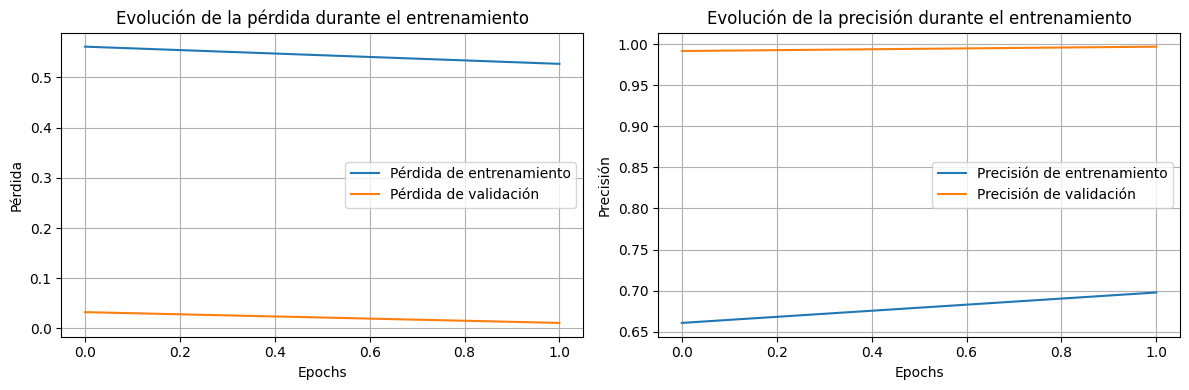

In [6]:
# Grafico la evolucion de perdida para los conjuntos de entrenamiento y prueba durante el entrenamiento
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Gráfico de pérdida
    ax1.plot(history.history['loss'], label='Pérdida de entrenamiento')
    ax1.plot(history.history['val_loss'], label='Pérdida de validación')
    ax1.set_title('Evolución de la pérdida durante el entrenamiento')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)

    # Gráfico de precisión
    ax2.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    ax2.plot(history.history['val_accuracy'], label='Precisión de validación')
    ax2.set_title('Evolución de la precisión durante el entrenamiento')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

---

<br>
<br>
<br>

## Validando el modelo

Tras el entrenamiento, revisamos la calidad del modelo, enfrentadolo con el conjunto de prueba, y accediendo a las metricas que reflejan las predicciones para este subset.

In [7]:
# Genero predicciones para el conjunto de prueba
y_pred = model.predict(test_data)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

conf_matrix = confusion_matrix(test_data.classes, y_pred)
class_report = classification_report(test_data.classes, y_pred)

print(conf_matrix)
print(class_report)

4/4 [==============================] - 1s 218ms/step
[[268   0]
 [  3 235]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       268
           1       1.00      0.99      0.99       238

    accuracy                           0.99       506
   macro avg       0.99      0.99      0.99       506
weighted avg       0.99      0.99      0.99       506



In [8]:
## MÉTRICAS DE CLASIFICACIÓN

print(f"F1-Score ==> {round(f1_score(test_data.labels, y_pred), 3)}")
print(f"Recall ==> {round(recall_score(test_data.labels, y_pred), 3)}")
print(f"Precision ==> {round(precision_score(test_data.labels, y_pred), 3)}")
print(f"Accuracy ==> {round(accuracy_score(test_data.labels, y_pred), 3)}")

F1-Score ==> 0.994
Recall ==> 0.987
Precision ==> 1.0
Accuracy ==> 0.994


El modelo entrenado mediante transferencia de aprendizaje lo hace realmente bien. De hecho, es capaz de predecir correctamente todas las instancias positivas de entrenamiento, sin generar falsos negativos (los falsos positivos no tienen una importancia tan critica en este caso). Este modelo es el que voy a utilizar en producción, pues el resultado es prácticamente perfecto.

In [9]:
# Guardo el modelo entrenado
base_model_path = "../src/trained_models/"
model.save(os.path.join(base_model_path, "residual_net_aug_model.keras"))

print("Modelo guardado correctamente.")

Modelo guardado correctamente.
